# 2D plate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part I: Functions

## 1. Solution Function

In [2]:
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

## 2. Shape function Q8

In [3]:
def shapeFuncQ8(xi,eta):
    shape = np.zeros((8,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta)*(-xi-eta-1),
                               (1+xi)*(1-eta)*(xi-eta-1),
                               (1+xi)*(1+eta)*(xi+eta-1),
                               (1-xi)*(1+eta)*(-xi+eta-1),
                               2*(1-xi*xi)*(1-eta),
                               2*(1+xi)*(1-eta*eta),
                               2*(1-xi*xi)*(1+eta),
                               2*(1-xi)*(1-eta*eta)])
    
    nderiv = np.zeros((8,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta)*(-xi-eta-1)-(1-xi)*(1-eta),-(1-xi)*(-xi-eta-1)-(1-xi)*(1-eta)])
    nderiv[1,:] = 1/4*np.array([(1-eta)*(xi-eta-1)+(1+xi)*(1-eta),-(1+xi)*(xi-eta-1)-(1+xi)*(1-eta)])
    nderiv[2,:] = 1/4*np.array([(1+eta)*(xi+eta-1)+(1+xi)*(1+eta),(1+xi)*(xi+eta-1)+(1+xi)*(1+eta)])
    nderiv[3,:] = 1/4*np.array([-(1+eta)*(-xi+eta-1)-(1-xi)*(1+eta),(1-xi)*(-xi+eta-1)+(1-xi)*(1+eta)])
    
    nderiv[4,:] = 1/2*np.array([(-2*xi)*(1-eta),-(1-xi*xi)])
    nderiv[5,:] = 1/2*np.array([(1-eta*eta),(1+xi)*(-2*eta)])
    nderiv[6,:] = 1/2*np.array([(-2*xi)*(1+eta),(1-xi*xi)])
    nderiv[7,:] = 1/2*np.array([-(1-eta*eta),(1-xi)*(-2*eta)])
    
    return shape, nderiv

## 3. Jacobian Function

In [4]:
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

## 4.Gauss Quadrature Q8

In [5]:
def gaussQuadratureQ8(option):
    if option == 2: # full 2nd order integration: 3x3=9 gauss points
        locations = np.array([[-np.sqrt(3/5), -np.sqrt(3/5)],
                              [0, -np.sqrt(3/5)],
                              [np.sqrt(3/5),  -np.sqrt(3/5)],
                              [-np.sqrt(3/5), 0],
                              [0, 0],
                              [np.sqrt(3/5), 0],
                              [-np.sqrt(3/5),  np.sqrt(3/5)],
                              [0, np.sqrt(3/5)],
                              [np.sqrt(3/5),  np.sqrt(3/5)]])
        weights = np.array([[25/81],[40/81],[25/81],[40/81],[64/81],[40/81],[25/81],[40/81],[25/81]])
        
    elif option == 1: # (linear)integration: 2x2=4 gauss points
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
        
    else: # 1x1=1: one gauss point
        locations =np.zeros((1,2))
        weights = 4*np.ones((1,1))
        
    return weights,locations

## 5. Stiffness matrix Q8

In [6]:
def formStiffness2DQ8(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadratureQ8(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((16,1))
        eDof[0:8,0] = id
        eDof[8:16,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop over Gauss points
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]                                                 
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ8(xi,eta)

            # Jacobian matrix, inverse of Jacobian    
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])
            
            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

## 7. Function_Plot mesh

In [7]:
# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
###    plt.show()

In [8]:
# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nE):
    # nE = element number
    nnel = np.size(eNodes,1) # number of nodes per element
    X = np.zeros((nnel,nE))
    Y = np.zeros((nnel,nE))
    
    for iel in range(nE):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
###     plt.show()

# Part 2: Main Programe

## 2.1. Input parameters: geometry & material

In [9]:
# Material Pros
E = 2e11
h = 0.01
pois = 0.3
R1 = 0.4
R2 = 0.5
tol = 1e-6

In [10]:
# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates

In [11]:
# dfnode = pd.read_csv('NLISTQ8a.csv', header=None)
# dfnode = pd.read_csv('NLISTQ8b.csv', header=None)
# dfnode = pd.read_csv('NLISTQ8c.csv', header=None)
dfnode = pd.read_csv('NLISTQ8d.csv', header=None)

dfnode.head(5)

0                  1             2    3
0  LIST ALL    SELECTED NODES.  DSYS=      0  NaN
1  SORT TAB  LE ON  NODE  NODE          NODE  NaN
2       NaN                NaN           NaN  NaN
3      NODE                  X             Y    Z
4         1                  1           0.5    0

In [12]:
dfnode = dfnode.dropna(axis=0)
dfnode.head()

0            1            2  3
3  NODE            X            Y  Z
4     1            1          0.5  0
5     2          0.5            1  0
6     3  0.999975291  0.504970793  0
7     4  0.999901165  0.509941094  0

In [13]:
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

0            1            2  3
4  1            1          0.5  0
5  2          0.5            1  0
6  3  0.999975291  0.504970793  0
7  4  0.999901165  0.509941094  0
8  5   0.99977763  0.514910413  0

In [14]:
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
type(xy)

pandas.core.frame.DataFrame

In [15]:
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
# xy

### 2.2.2. Import nodal connectivities

In [16]:
# dfeNode = pd.read_csv('ELISTQ8a.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ8b.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ8c.csv', header=None)
dfeNode = pd.read_csv('ELISTQ8d.csv', header=None)

dfeNode = dfeNode.dropna(axis=0)
# dfeNode.head(10)

eNodes = dfeNode[[6,7,8,9,10,11,12,13]]
eNodes.head()
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head(2)

6     7       8       9       10     11      12      13
4  3409  3318  4469.0  4388.0  2328.0  335.0  2846.0  2847.0
5  4387  4469  3318.0  3242.0  2851.0  335.0  2462.0   336.0

In [17]:
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

(1460, 8)

### 2.2.3 plot mesh

In [18]:
eNodesb = eNodes.copy()
eNodesb[:,0] = eNodes[:,0]
eNodesb[:,1] = eNodes[:,4]
eNodesb[:,2] = eNodes[:,1]
eNodesb[:,3] = eNodes[:,5]
eNodesb[:,4] = eNodes[:,2]
eNodesb[:,5] = eNodes[:,6]
eNodesb[:,6] = eNodes[:,3]
eNodesb[:,7] = eNodes[:,7]

PlotMeshb(xy,eNodesb,nE)
plt.scatter(xy[:,0],xy[:,1])
plt.show()

## 2.3. Calculate stiffness matrix

In [19]:
K = formStiffness2DQ8(nDof,nE,eNodes,nP,xy,C,h,2)
K.shape

(9094, 9094)

## 2.4 Boundary condition

In [20]:
fixP = np.argwhere(xy[:,0]<=R2+tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

array([   1,  159,  160,  161,  162,  163,  164,  165,  166,  167,  168,
        169,  170,  171,  172,  173,  174,  175,  176,  177,  178,  179,
        180,  181,  182,  183,  184,  185,  186,  187,  188,  189,  190,
        191,  192,  193,  194,  195,  196,  197,  198, 4548, 4706, 4707,
       4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718,
       4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729,
       4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740,
       4741, 4742, 4743, 4744, 4745], dtype=int64)

## 2.5 Loading

In [21]:
dfx = 5e7
force = np.zeros((nDof,1))

In [22]:
loadP3 = np.argwhere((xy[:,0]>=2*R1-tol) & (xy[:,1]<=R2+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
loadP

array([[199],
       [295],
       [296],
       [297],
       [298],
       [299],
       [300],
       [301],
       [302],
       [303],
       [304],
       [305],
       [306],
       [307],
       [308],
       [309],
       [310],
       [311],
       [312],
       [313],
       [314],
       [315],
       [316],
       [317],
       [318],
       [319],
       [320],
       [321],
       [322],
       [323],
       [324],
       [325],
       [326],
       [327],
       [328],
       [329],
       [330],
       [331],
       [332],
       [333],
       [  0]], dtype=int64)

In [23]:
for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

## 2.6. Solve EOM

In [24]:
disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

## 2.7. Postprocessing

In [25]:
scale = 0.1
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

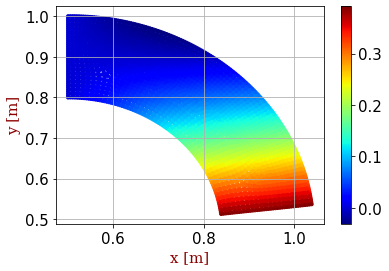

In [26]:
## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [27]:
max(dispu)

0.3917804765843857

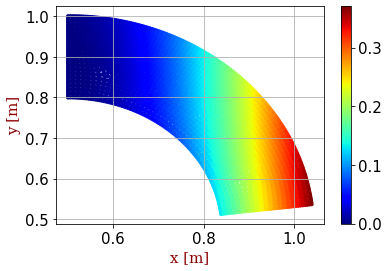

In [28]:
## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [29]:
max(dispv)

0.3701421390005741